# visualize_data

This script creates visualizations of a number of properties of the previously produced data.

In [1]:
# import required modules
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import statistics
from collections import Counter
import matplotlib.dates as mdates
# from statannot import add_stat_annotation

In [2]:
# import table
mm = pd.read_csv('../data_tables/metadataMatrix_filtered.csv')
# mm

In [3]:
# define mode function for a list of items with two possible values...
# ...based on which is mentioned more, or 'Multiple' if score is equal
def getMode(items):
    try:
        r = statistics.mode(items)
    except:
        r = 'Multiple'
    return r

### Visualize by paper

Consider the data in units of PubMed publications.

In [4]:
fig_dims = (9, 6)

paps = mm[['pmc_ID', 'repository', 'reuse_role', 'pmc_date', 'class']]
paps = paps.groupby(['pmc_ID'], as_index = False).agg({'repository': lambda x: getMode(x), 
                                                       'reuse_role': lambda r: getMode(r),
                                                       'pmc_date': lambda d: max(d),
                                                       'class': lambda c: getMode(c)})
# paps

In [5]:
# paps2 = mm[['pmc_ID', 'repository', 'class', 'reuse_role', 'pmc_date', 'converted_accession', 'library_strategy']]
# paps2 = paps2.groupby(['pmc_ID'], as_index = False).agg({'repository': lambda x: getMode(x),
#                                                          'class': lambda c: getMode(c),
#                                                         'reuse_role': lambda r: getMode(r),
#                                                         'pmc_date': lambda d: max(d),
#                                                         'converted_accession': lambda d: getMode(d),
#                                                         'library_strategy': lambda d: getMode(d)})
# paps2

In [6]:
# how many papers are in GEO, SRA, or both?
rc = Counter(paps['class'])
repoCounts = pd.DataFrame.from_dict(rc, orient = 'index').reset_index()
repoCounts = repoCounts.dropna()
repoCounts.columns = ['repository', 'count']
repoCounts['percent'] = repoCounts['count'] / repoCounts['count'].sum()
repoCounts = repoCounts.sort_values(by = "percent", ascending = False)

repoCounts_T = repoCounts.T

cols = repoCounts_T.iloc[0, :]

repoCounts_T.columns = cols
repoCounts_T = repoCounts_T.iloc[2:,:]
# repoCounts_T

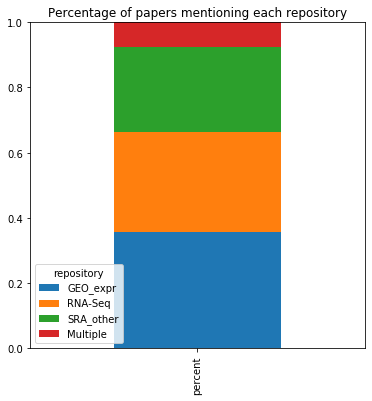

In [7]:
# visualize distribution of repositories mentioned by papers

ax = repoCounts_T.plot(kind = 'bar', stacked = True, figsize = (6, 6))
plt.ylim(0,1)
title = "Percentage of papers mentioning each repository"
ax.set_title(title)
plt.savefig("../figures/pctMentioningBar.png")

In [8]:
# how many papers reuse, generate, or both?
rc = {'class':['generating', 'reusing', 'both']}

for c in ["RNA-Seq", "GEO_expr", "SRA_other"]:
    rec = Counter(paps.loc[paps['class'] == c, :]['reuse_role'])
    reCo = pd.DataFrame.from_dict(rec, orient = 'index').reset_index()
    reCo.columns = ['reuse_role', 'count']
    reCo['percent'] = reCo['count'] / reCo['count'].sum()
    rc[c] = reCo['percent']
    
reuseCounts = pd.DataFrame(rc).T
reuseCounts.columns = reuseCounts.iloc[0,:]
reuseCounts = reuseCounts.iloc[1:,:]
reuseCounts = reuseCounts.sort_values(by = "reusing", ascending = False)
# reuseCounts

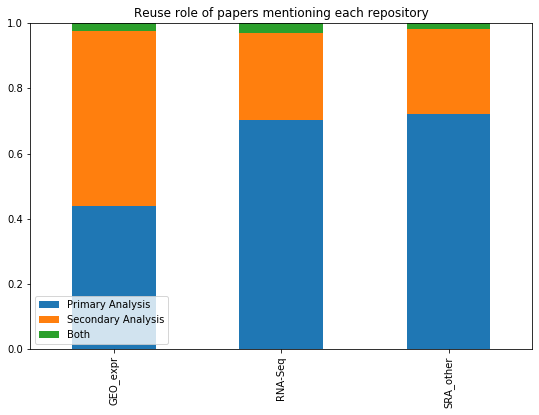

In [9]:
ax = reuseCounts.plot(kind = 'bar', stacked = True, figsize = fig_dims)
plt.ylim(0,1)
title = "Reuse role of papers mentioning each repository"
ax.set_title(title)
ax.legend(["Primary Analysis", "Secondary Analysis", "Both"])
plt.savefig("../figures/reuseRoleRepos.png")

In [10]:
# visualize reuse and repository distribution across the years
# add year column
fmt = '%Y-%m-%d'
paps.loc[:,'pmc_date'] = pd.to_datetime(paps['pmc_date'], format = fmt)
paps['year'] = paps['pmc_date'].dt.year
# paps

In [11]:
# get repository counts per date
# repo_byDate = paps.groupby(['year', 'repository'])['repository'].count().to_frame(name = 'repo_count').reset_index()
repo_byDate = paps.groupby(['year', 'class'])['class'].count().to_frame(name = 'repo_count').reset_index()
# repo_byDate

In [12]:
dropme = repo_byDate[repo_byDate['year'] == 2020].index
repo_byDate.drop(dropme, inplace = True)

years = repo_byDate['year'].drop_duplicates().to_list()
years = [int(i) for i in years]

In [13]:
z = {'year':years, 'repository':'GEO', 'repo_count':0}
z2 = {'year':years, 'repository':'SRA', 'repo_count':0}
z3 = {'year':years, 'repository':'Multiple', 'repo_count':0}

zerosGEO = pd.DataFrame(data = z)
zerosSRA = pd.DataFrame(data = z2)
zerosBoth = pd.DataFrame(data = z3)

gexp_byDate = repo_byDate.loc[repo_byDate['class'] == "GEO_expr", :].append(zerosGEO).groupby(['year'], sort = False).sum().reset_index().cumsum()
rnaseq_byDate = repo_byDate.loc[repo_byDate['class'] == "RNA-Seq", :].append(zerosGEO).groupby(['year'], sort = False).sum().reset_index().cumsum()
sra_byDate = repo_byDate.loc[repo_byDate['class'] == "SRA_other", :].append(zerosSRA).groupby(['year'], sort = False).sum().reset_index().cumsum()
mult_byDate = repo_byDate.loc[repo_byDate['class'] == "Multiple", :].append(zerosBoth).groupby(['year'], sort = False).sum().reset_index().cumsum()


# geo_byDate = repo_byDate.loc[repo_byDate['repository'] == 'GEO', :].append(zerosGEO).groupby(['year']).sum().reset_index().cumsum()
# sra_byDate = repo_byDate.loc[repo_byDate['repository'] == 'SRA', :].append(zerosSRA).groupby(['year']).sum().reset_index().cumsum()
# bothRepo_byDate = repo_byDate.loc[repo_byDate['repository'] == 'Multiple', :].append(zerosBoth).groupby(['year']).sum().reset_index().cumsum()

/Users/niko/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


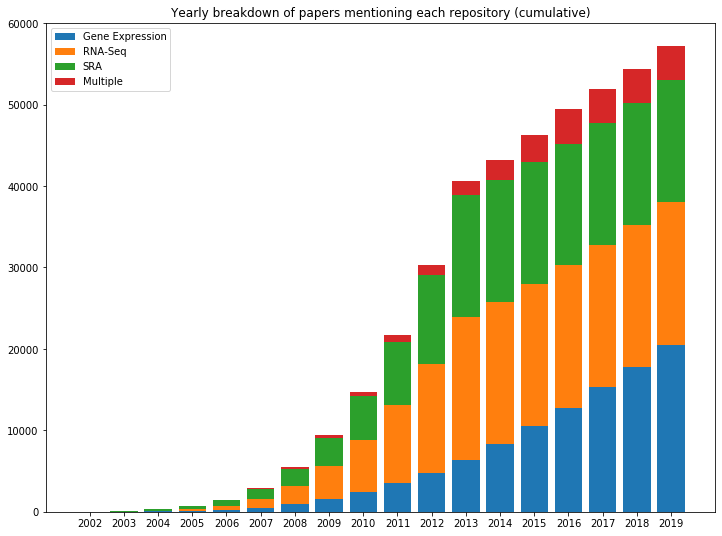

In [14]:
fig, ax = plt.subplots(figsize = (12, 9))

plt.bar(years, gexp_byDate['repo_count'])
plt.bar(years, rnaseq_byDate['repo_count'], 
        bottom = gexp_byDate['repo_count'])
plt.bar(years, sra_byDate['repo_count'], 
        bottom = [i+j for i, j in zip(gexp_byDate['repo_count'], rnaseq_byDate['repo_count'])])
plt.bar(years, mult_byDate['repo_count'], 
        bottom = [i+j+k for i, j, k in zip(gexp_byDate['repo_count'], rnaseq_byDate['repo_count'], sra_byDate['repo_count'])])

plt.xticks(ticks = years)
title = "Yearly breakdown of papers mentioning each repository (cumulative)"
plt.title(title)
plt.legend(["Gene Expression", "RNA-Seq", "SRA", "Multiple"], loc = 'upper left')
plt.savefig("../figures/repoTimeSer.png")
plt.show()

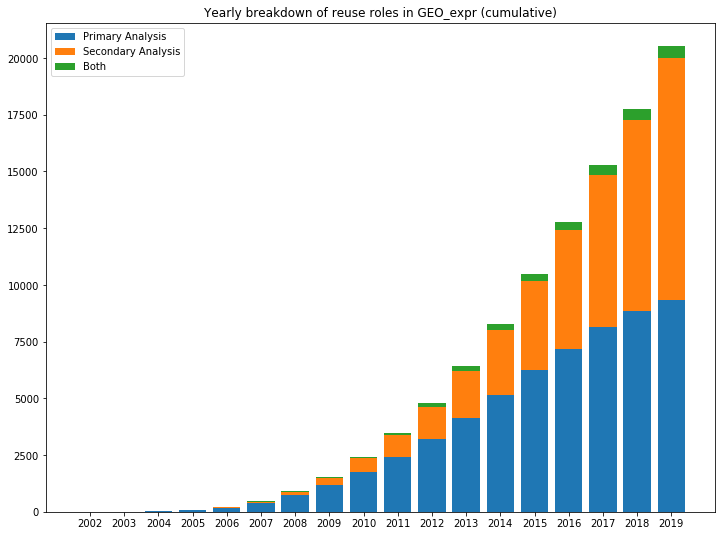

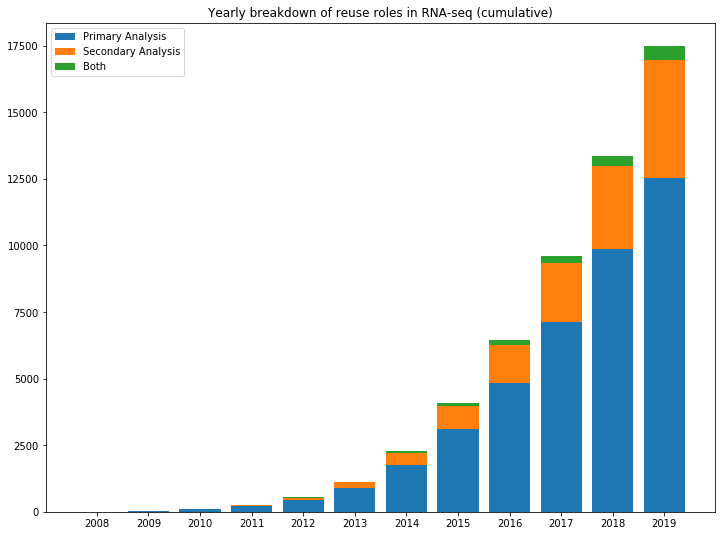

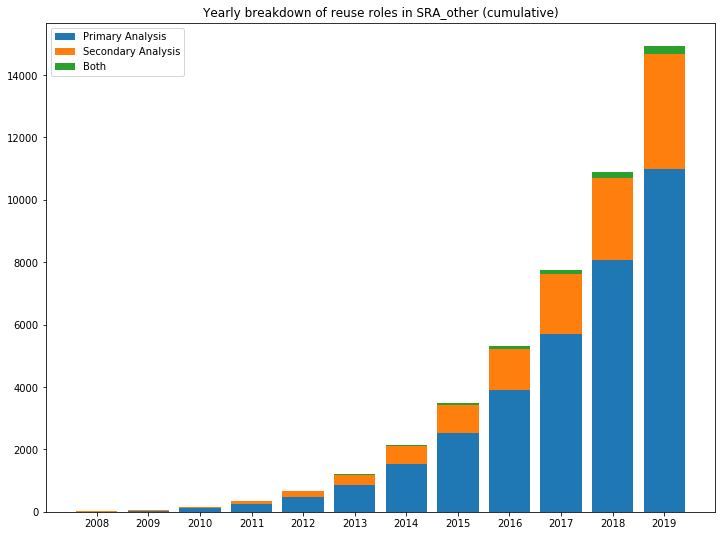

In [15]:
# get reuse counts per date

# CUMULATIVE
reuse_byDateGEOexpr = paps.loc[paps['class'] == 'GEO_expr', :].groupby(['year', 'reuse_role'])['reuse_role'].count().to_frame(name = 'reuse_count').reset_index()
reuse_byDateRNAseq = paps.loc[paps['class'] == 'RNA-Seq', :].groupby(['year', 'reuse_role'])['reuse_role'].count().to_frame(name = 'reuse_count').reset_index()
reuse_byDateSRAother = paps.loc[paps['class'] == 'SRA_other', :].groupby(['year', 'reuse_role'])['reuse_role'].count().to_frame(name = 'reuse_count').reset_index()

timesthru = 0
for reuse_byDate in [reuse_byDateGEOexpr, reuse_byDateRNAseq, reuse_byDateSRAother]:
    
    dropme = reuse_byDate[reuse_byDate['year'] == 2020].index
    reuse_byDate.drop(dropme, inplace = True)

    years = reuse_byDate['year'].drop_duplicates().to_list()

    z = {'year':years, 'reuse_role':'G', 'reuse_count':0}
    z2 = {'year':years, 'reuse_role':'R', 'reuse_count':0}
    z3 = {'year':years, 'reuse_role':'Multiple', 'reuse_count':0}

    zerosG = pd.DataFrame(data = z)
    zerosR = pd.DataFrame(data = z2)
    zerosBoth = pd.DataFrame(data = z3)

    R_byDate = reuse_byDate.loc[reuse_byDate['reuse_role'] == 'R', :].append(zerosG).groupby(['year']).sum().reset_index().cumsum()
    G_byDate = reuse_byDate.loc[reuse_byDate['reuse_role'] == 'G', :].append(zerosR).groupby(['year']).sum().reset_index().cumsum()
    bothReuse_byDate = reuse_byDate.loc[reuse_byDate['reuse_role'] == 'Multiple', :].append(zerosBoth).groupby(['year']).sum().reset_index().cumsum()

    fig, ax = plt.subplots(figsize = (12, 9))

    plt.bar(years, G_byDate['reuse_count'])
    plt.bar(years, R_byDate['reuse_count'], 
            bottom = G_byDate['reuse_count'])
    plt.bar(years, bothReuse_byDate['reuse_count'], 
            bottom = [i+j for i, j in zip(G_byDate['reuse_count'], R_byDate['reuse_count'])])

    if timesthru == 0:
        cls = "GEO_expr"
    elif timesthru == 1:
        cls = "RNA-seq"
    elif timesthru == 2:
        cls = "SRA_other"
    timesthru = timesthru + 1
        
    plt.xticks(ticks = years)
    title = "Yearly breakdown of reuse roles in " + str(cls) + " (cumulative)"
    plt.title(title)
    plt.legend(["Primary Analysis", "Secondary Analysis", "Both"], loc = 'upper left')
    filename = "../figures/cumTimeSer_" + cls + ".png"
    plt.savefig(filename)
    plt.show()

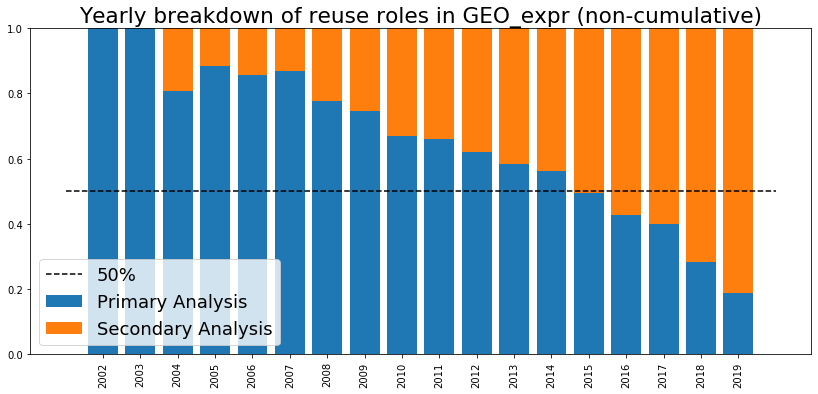

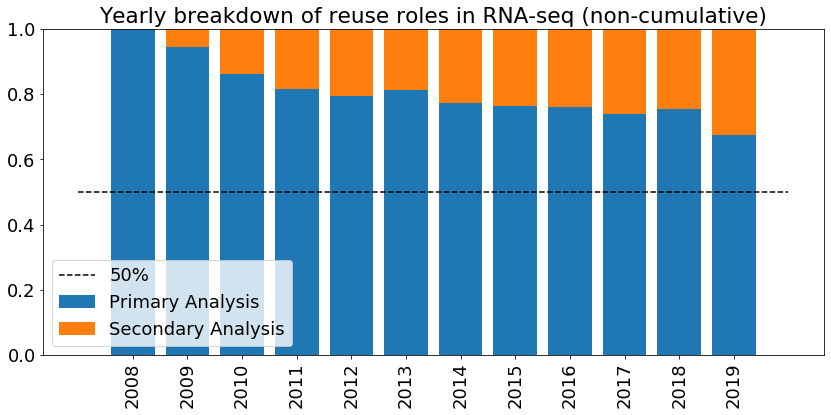

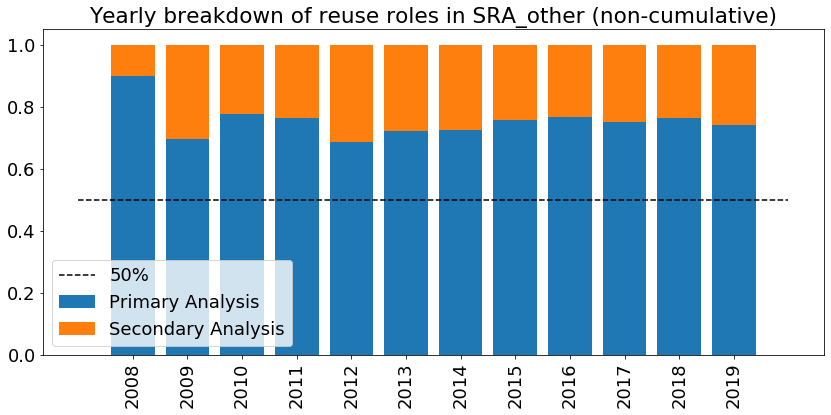

In [16]:
# NON-CUMULATIVE
timesthru = 0
for reuse_byDate in [reuse_byDateGEOexpr, reuse_byDateRNAseq, reuse_byDateSRAother]:
    
    dropme = reuse_byDate[reuse_byDate['year'] == 2020].index
    reuse_byDate.drop(dropme, inplace = True)

    years = reuse_byDate['year'].drop_duplicates().to_list()

    z = {'year':years, 'reuse_role':'G', 'reuse_count':0}
    z2 = {'year':years, 'reuse_role':'R', 'reuse_count':0}

    zerosG = pd.DataFrame(data = z)
    zerosR = pd.DataFrame(data = z2)

    R_byDate = reuse_byDate.loc[reuse_byDate['reuse_role'] == 'R', :].append(zerosG).groupby(['year']).sum().reset_index()
    G_byDate = reuse_byDate.loc[reuse_byDate['reuse_role'] == 'G', :].append(zerosR).groupby(['year']).sum().reset_index()
    
    fig, ax = plt.subplots(figsize = (14, 6))
    
    total_counts = G_byDate['reuse_count'] + R_byDate['reuse_count'] # + bothReuse_byDate['reuse_count']
    plt.bar(years, G_byDate['reuse_count'] / total_counts)
    plt.bar(years, R_byDate['reuse_count'] / total_counts, 
            bottom = G_byDate['reuse_count'] / total_counts)
    
    if timesthru == 0:
        cls = "GEO_expr"
        plt.plot([2001, 2020], [0.5, 0.5], '--', color = 'black')
    elif timesthru == 1:
        cls = "RNA-seq"
        plt.plot([2007, 2020], [0.5, 0.5], '--', color = 'black')
    elif timesthru == 2:
        cls = "SRA_other"
        plt.plot([2007, 2020], [0.5, 0.5], '--', color = 'black')
    timesthru = timesthru + 1
    
    plt.rc('font', size = 18)
    plt.xticks(ticks = years)
    title = "Yearly breakdown of reuse roles in " + str(cls) + " (non-cumulative)"
    plt.title(title)
    plt.legend(["50%", "Primary Analysis", "Secondary Analysis"], loc = 'lower left')
    plt.xticks(rotation = 90)
    
    filename = "../figures/nonCumTimeSer_" + cls + ".png"
    plt.savefig(filename)
    plt.show()
        
plt.rc('font', size = 12)

In [17]:
# remove papers with 'Multiple' listed for either repository or reuse_role
paps = paps.loc[paps['repository'] != 'Multiple', :].loc[paps['reuse_role'] != 'Multiple', :]
# paps

### Visualize by dataset

Consider the data in units of SRA and GEO datasets.

In [18]:
# how many times is each dataset used?
# take the slice we need from mm
accs = mm[['converted_accession', 'repository', 'reuse_count', 'norm_reuse_count', 'time_public', 'class']].drop_duplicates()
# accs['reuse_count'] = accs['total_use_count'] - 1
# accs

In [19]:
# what percentage of datasets are used more than once (re-used at least once)?
accs['wasReused'] = accs['reuse_count'] * accs['time_public'] >= 1
accsPcts = accs.groupby('class', as_index = False).agg({'wasReused':'mean'})
accsPcts = accsPcts.rename(columns = {'wasReused':'pctReused'})
# accsPcts

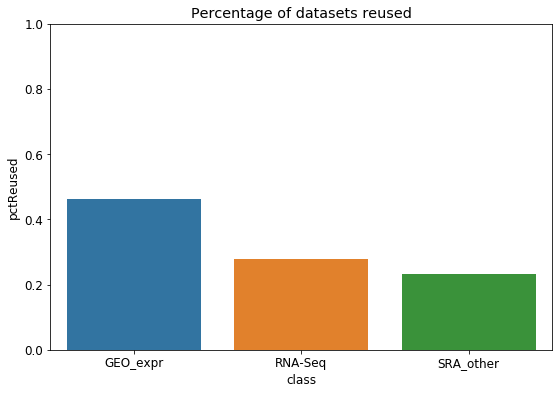

In [20]:
# plot barplot showing percentage of datasets reused in GEO and SRA
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data = accsPcts, x = 'class', y = 'pctReused', ax = ax)
plt.ylim(0,1)
title = "Percentage of datasets reused"
ax.set_title(title)
plt.savefig("../figures/pctDataReused.png")
plt.show()

In [21]:
# plot distribution of reuse for each unique dataset, first using a boxplot
# each point is a dataset

# remove datasets not reused at all
accs_filt = accs.loc[accs['reuse_count'] > 0, :]
# accs_filt

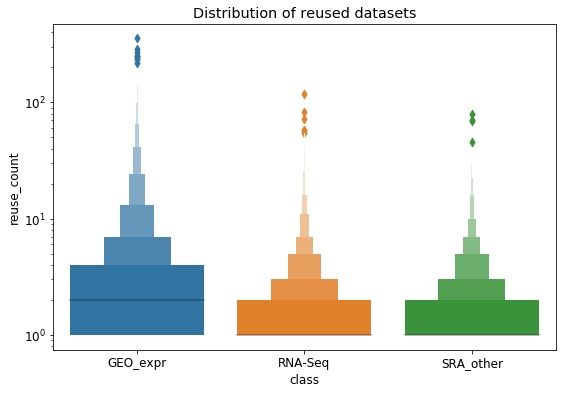

In [22]:
fig, ax = plt.subplots(figsize=fig_dims)
# datasets_box = sns.boxplot(data = accs_filt, x = 'class', y = 'reuse_count', showfliers = False, ax = ax,
#                           order = ["GEO_expr", "RNA-Seq", "SRA_other"])
datasets_box = sns.boxenplot(data = accs_filt, x = 'class', y = 'reuse_count', ax = ax,
                            order = ["GEO_expr", "RNA-Seq", "SRA_other"])
datasets_box.set(yscale = 'log')
title = "Distribution of reused datasets"
ax.set_title(title)
plt.savefig("../figures/reuseDistRepos.png")
plt.show()

In [23]:
sraMean = statistics.mean(accs_filt.loc[accs_filt['class'] == "SRA_other"]['reuse_count'])
gexpMean = statistics.mean(accs_filt.loc[accs_filt['class'] == "GEO_expr"]['reuse_count'])
rnaseqMean = statistics.mean(accs_filt.loc[accs_filt['class'] == "RNA-Seq"]['reuse_count'])
print("SRA mean reuse count is " + str(sraMean))
print("RNA-Seq mean reuse count is " + str(rnaseqMean))
print("Gene expression mean reuse count is " + str(gexpMean))

sraMed = statistics.median(accs_filt.loc[accs_filt['class'] == "SRA_other"]['reuse_count'])
gexpMed = statistics.median(accs_filt.loc[accs_filt['class'] == "GEO_expr"]['reuse_count'])
rnaseqMed = statistics.median(accs_filt.loc[accs_filt['class'] == "RNA-Seq"]['reuse_count'])
print("SRA median reuse count is " + str(sraMed))
print("RNA-Seq median reuse count is " + str(rnaseqMed))
print("Gene expression median reuse count is " + str(gexpMed))

SRA mean reuse count is 2.005536514632217
RNA-Seq mean reuse count is 2.090343818580834
Gene expression mean reuse count is 4.774293457220287
SRA median reuse count is 1
RNA-Seq median reuse count is 1.0
Gene expression median reuse count is 2


In [24]:
# scipy.stats.ttest_ind(a = accs_filt.loc[accs_filt['repository'] == 'GEO', :]['reuse_count'],
#                      b = accs_filt.loc[accs_filt['repository'] == 'SRA', :]['reuse_count'],
#                      equal_var = False)

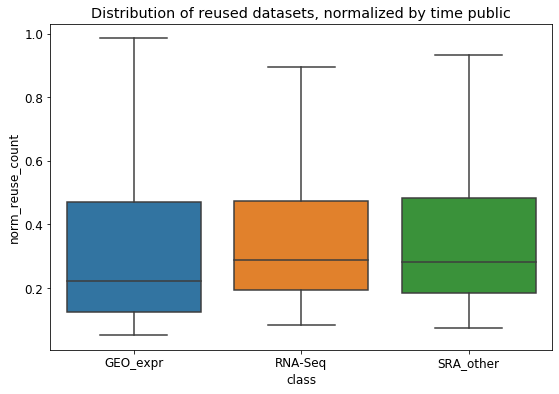

In [25]:
# plot the distribution of reuse for each dataset, normalized by time public
fig, ax = plt.subplots(figsize=fig_dims)
datasets_box = sns.boxplot(data = accs_filt, x = 'class', y = 'norm_reuse_count', showfliers = False, ax = ax,
                          order = ["GEO_expr", "RNA-Seq", "SRA_other"])
# datasets_box = sns.boxenplot(data = accs_filt, x = 'class', y = 'norm_reuse_count', ax = ax,
#                             order = ["GEO_expr", "RNA-Seq", "SRA_other"])
# datasets_box.set(yscale = 'log')
title = "Distribution of reused datasets, normalized by time public"
ax.set_title(title)
plt.savefig("../figures/reuseDistRepos_norm.png")
plt.show()

### Visualize by feature

Consider the data in units of each dataset's reuse count.

In [26]:
mm_filt = pd.merge(paps, mm, how = 'left', on = ['pmc_ID', 'repository', 'reuse_role', 'class'])
# mm_filt

In [27]:
accs_feat = mm_filt.drop(labels = ['pmc_ID', 'accession', 'pmc_date_x'], axis = 1).drop_duplicates()
accs_feat = accs_feat.rename(columns = {'pmc_date_y' : 'pmc_date'})
# accs_feat['reuse_count'] = (accs_feat['total_use_count'] - 1)
accs_feat

,repository,reuse_role,class,year,journal,converted_accession,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,today,time_public,reuse_count,norm_reuse_count,pub_delay
0,GEO,G,GEO_expr,2005,PLoS_Biol,GSE2227,2005-03-08 00:00:00,2005-02-03,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-09-28,15.660274,1.0,0.063856,33.0
1,GEO,G,GEO_expr,2005,BMC_Genomics,GSE1939,2005-03-05 00:00:00,2005-03-15,Mus musculus,SAGE NlaIII,Expression_Array,NaN,NaN,NaN,2020-09-28,15.550685,0.0,0.000000,-10.0
3,GEO,R,GEO_expr,2005,BMC_Biol,GSE54,2005-03-22,2002-06-19,Arabidopsis thaliana,SAGE NlaIII,Expression_Array,NaN,NaN,NaN,2020-09-28,18.290411,1.0,0.054673,NaN
4,GEO,G,GEO_expr,2005,Genome_Biol,GSE2193,2005-02-14 00:00:00,2005-02-21,Homo sapiens,spotted DNA/cDNA,Expression_Array,NaN,NaN,NaN,2020-09-28,15.610959,3.0,0.192173,-7.0
5,GEO,G,GEO_expr,2005,Genome_Biol,GSE2031,2005-02-28 00:00:00,2004-12-02,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-09-28,15.832877,2.0,0.126319,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143844,GEO,R,GEO_expr,2020,Hepatol_Commun,GSE5206;GSE5261,2020-03-15,NaN,NaN,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-09-28,NaN,3.0,NaN,NaN
143845,GEO,R,NaN,2020,Mol_Genet_Genomic_Med,GSE37754,2020-02-10,2013-11-01,Homo sapiens,NaN,NaN,NaN,NaN,NaN,2020-09-28,6.912329,4.0,0.578676,NaN
143846,GEO,R,NaN,2020,Mol_Genet_Genomic_Med,GSE37751,2020-02-10,2013-11-01,Homo sapiens,NaN,NaN,NaN,NaN,NaN,2020-09-28,6.912329,16.0,2.314705,NaN
143847,GEO,R,GEO_expr,2020,Mol_Genet_Genomic_Med,GSE71102,2020-02-12,2015-07-21,Homo sapiens,oligonucleotide beads,Expression_Array,NaN,NaN,NaN,2020-09-28,5.194521,1.0,0.192511,NaN


In [28]:
def inList(pot_vec, ref_vec):
    bools = []
    for i in pot_vec:
        if(type(i) == str):
            if(i in ref_vec):
                bools.append(True)
            else:
                bools.append(False)
        else:
            bools.append(False)
    return bools

In [29]:
# plot reuse per species

sc = Counter(accs_feat['species'])

specCounts = pd.DataFrame.from_dict(sc, orient = 'index').reset_index()
specCounts.columns = ['species', 'count']

accs_feat['is_human'] = accs_feat['species'] == 'Homo sapiens'
# specCounts

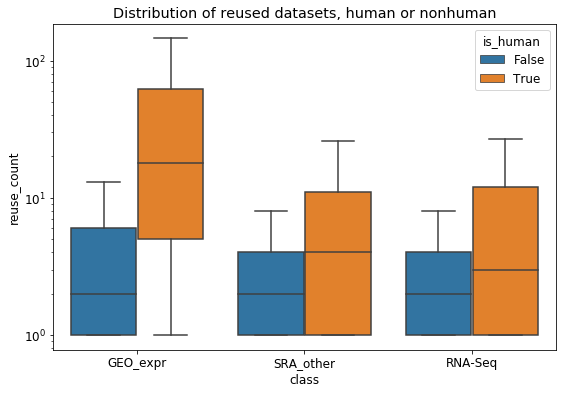

In [31]:
fig, ax = plt.subplots(figsize=fig_dims)
# sns.boxenplot(data = accs_feat.loc[accs_feat['reuse_count'] > 0, :], 
#               x = 'class', y = 'reuse_count', hue = 'is_human', ax = ax).set(yscale = 'log')
sns.boxplot(data = accs_feat.loc[accs_feat['reuse_count'] > 0, :], 
              x = 'class', y = 'reuse_count', hue = 'is_human', showfliers = False, ax = ax).set(yscale = 'log')
title = "Distribution of reused datasets, human or nonhuman"
ax.set_title(title)
plt.savefig("../figures/reuseDistHuman.png")
plt.show()

In [32]:
accs_feat_filt = accs_feat.loc[accs_feat['reuse_count'] > 0, :]
accs_feat_filtGEO = accs_feat_filt.loc[accs_feat_filt['repository'] == 'GEO', :]
accs_feat_filtSRA = accs_feat_filt.loc[accs_feat_filt['repository'] == 'SRA', :]

scipy.stats.ttest_ind(a = accs_feat_filtGEO.loc[accs_feat_filtGEO['is_human'] == True, :]['reuse_count'],
                     b = accs_feat_filtGEO.loc[accs_feat_filtGEO['is_human'] == False, :]['reuse_count'],
                     equal_var = False)
scipy.stats.ttest_ind(a = accs_feat_filtSRA.loc[accs_feat_filtSRA['is_human'] == True, :]['reuse_count'],
                     b = accs_feat_filtSRA.loc[accs_feat_filtSRA['is_human'] == False, :]['reuse_count'],
                     equal_var = False)

Ttest_indResult(statistic=12.072522975263979, pvalue=2.021375878009234e-32)

In [89]:
# plot RI distribution for species with most amount of datasets which are present in all 3 categories
# get the columns we want and group on species
specCounts = accs_feat[['converted_accession', 'species', 'class']].drop_duplicates()
specCounts = specCounts.groupby(['species'], as_index = False).agg({'converted_accession':'nunique',
                                                   'class':'nunique'})
specCounts.columns = ['species', 'acc_count', 'class_count']
# filter out species with datasets in less than all 3 categories
specCounts = specCounts.loc[specCounts['class_count'] > 2, :]
specCounts = specCounts.dropna().sort_values(by = 'acc_count', ascending = False)
# specCounts

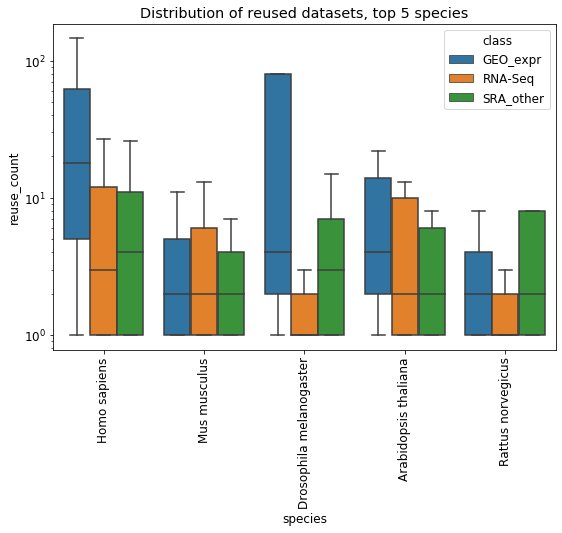

In [90]:
NUM_TOPSPECIES = 5

topSpec = specCounts.head(n = NUM_TOPSPECIES)['species'].to_list()
            
accs_top_spec = accs_feat.loc[inList(accs_feat['species'], topSpec), :].sort_values(by = 'reuse_count', ascending = False)

fig, ax = plt.subplots(figsize=fig_dims)
s = sns.boxplot(data = accs_top_spec.loc[accs_top_spec['reuse_count'] > 0, :], 
                x = 'species', y = 'reuse_count', hue = 'class', showfliers = False, ax = ax)
s.set(yscale = 'log')
# add_stat_annotation(data = accs_top_spec.loc[accs_top_spec['reuse_count'] > 0, :],
#                    x = 'species', y = 'reuse_count',
#                     box_pairs = [(("Homo sapiens", "GEO"), ("Homo sapiens"), ("SRA"))], test = 't-test_ind', ax = ax)
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
title = "Distribution of reused datasets, top " + str(NUM_TOPSPECIES) + " species"
ax.set_title(title)
plt.savefig("../figures/speciesDistHUE.png")
plt.show()

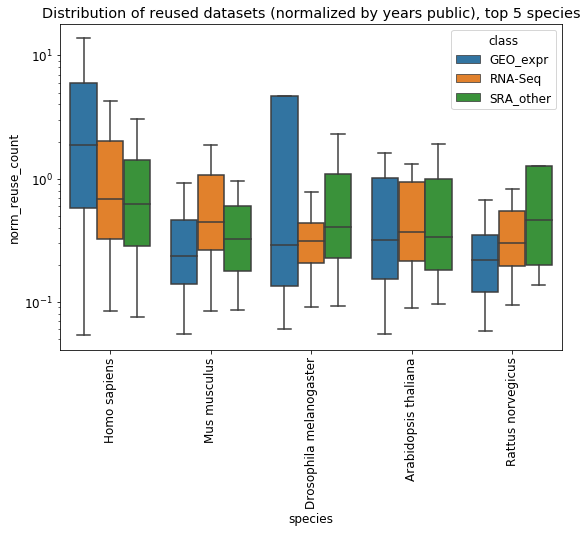

In [91]:
# plot reuse distribution for top 10 species, NRI

fig, ax = plt.subplots(figsize=fig_dims)
s = sns.boxplot(data = accs_top_spec.loc[accs_top_spec['reuse_count'] > 0, :], 
                x = 'species', y = 'norm_reuse_count', hue = 'class', showfliers = False, ax = ax)
s.set(yscale = 'log')
# add_stat_annotation(data = accs_top_spec.loc[accs_top_spec['reuse_count'] > 0, :],
#                    x = 'species', y = 'reuse_count',
#                     box_pairs = [(("Homo sapiens", "GEO"), ("Homo sapiens"), ("SRA"))], test = 't-test_ind', ax = ax)
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
title = "Distribution of reused datasets (normalized by years public), top " + str(NUM_TOPSPECIES) + " species"
ax.set_title(title)
plt.savefig("../figures/speciesDistHUE_NRI.png")
plt.show()

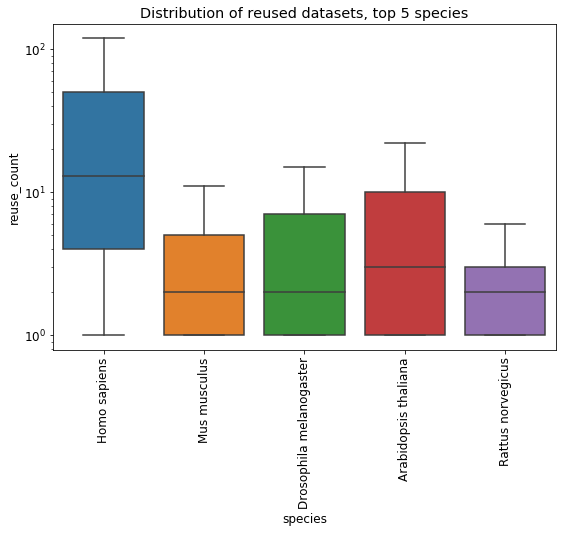

In [95]:
# plot species plot without the group hue, RI
fig, ax = plt.subplots(figsize=fig_dims)
s = sns.boxplot(data = accs_top_spec.loc[accs_top_spec['reuse_count'] > 0, :], 
                x = 'species', y = 'reuse_count', showfliers = False, ax = ax)
s.set(yscale = 'log')
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
title = "Distribution of reused datasets, top " + str(NUM_TOPSPECIES) + " species"
ax.set_title(title)
plt.savefig("../figures/speciesDist.png")
plt.show()

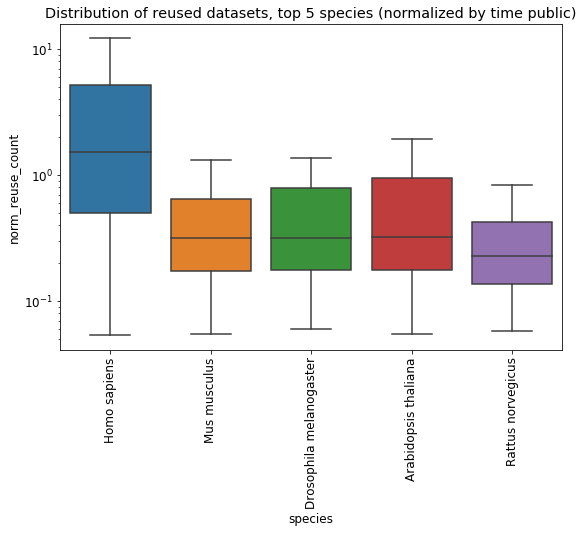

In [94]:
# plot species plot without the group hue, NRI
fig, ax = plt.subplots(figsize=fig_dims)
s = sns.boxplot(data = accs_top_spec.loc[accs_top_spec['reuse_count'] > 0, :], 
                x = 'species', y = 'norm_reuse_count', showfliers = False, ax = ax)
s.set(yscale = 'log')
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
title = "Distribution of reused datasets, top " + str(NUM_TOPSPECIES) + " species (normalized by time public)"
ax.set_title(title)
plt.savefig("../figures/speciesDist_NRI.png")
plt.show()

In [36]:
# plot reuse per library strategy in SRA

lc = Counter(accs_feat.loc[accs_feat['repository'] == "SRA", :]['library_strategy'])

libCounts = pd.DataFrame.from_dict(lc, orient = 'index').reset_index()
libCounts.columns = ['library_strategy', 'count']
# print(specCounts.head(n = 20))

NUM_TOPLIBS = 10

topLibsSRA = libCounts.dropna().sort_values(by = 'count', ascending = False).head(n = NUM_TOPLIBS)['library_strategy'].to_list()

accs_top_libsSRA = accs_feat.loc[inList(accs_feat['library_strategy'], topLibsSRA), :].sort_values(by = 'reuse_count', ascending = False)

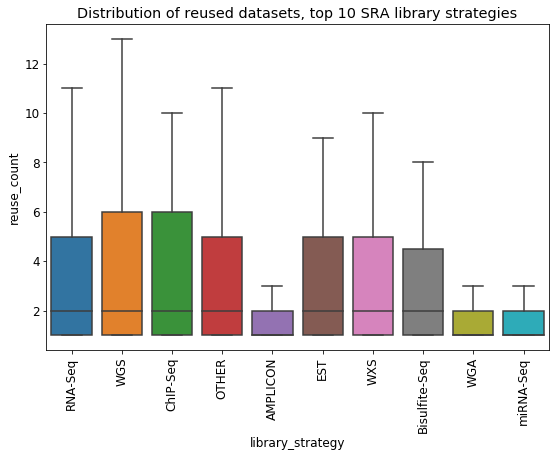

In [37]:
# plot library strategies, RI
fig, ax = plt.subplots(figsize=fig_dims)
s = sns.boxplot(data = accs_top_libsSRA.loc[accs_top_libsSRA['reuse_count'] > 0, :], 
                x = 'library_strategy', y = 'reuse_count', showfliers = False, ax = ax)
# s.set(yscale = 'log')
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
title = "Distribution of reused datasets, top " + str(NUM_TOPLIBS) + " SRA library strategies"
ax.set_title(title)
plt.savefig("../figures/libstratDist.png")
plt.show()

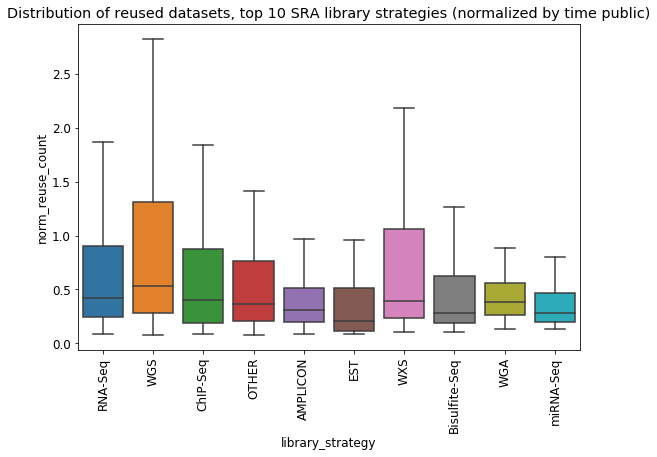

In [97]:
# plot library strategies, NRI
fig, ax = plt.subplots(figsize=fig_dims)
s = sns.boxplot(data = accs_top_libsSRA.loc[accs_top_libsSRA['reuse_count'] > 0, :], 
                x = 'library_strategy', y = 'norm_reuse_count', showfliers = False, ax = ax)
# s.set(yscale = 'log')
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
title = "Distribution of reused datasets, top " + str(NUM_TOPLIBS) + " SRA library strategies (normalized by time public)"
ax.set_title(title)
plt.savefig("../figures/libstratDist_NRI.png")
plt.show()

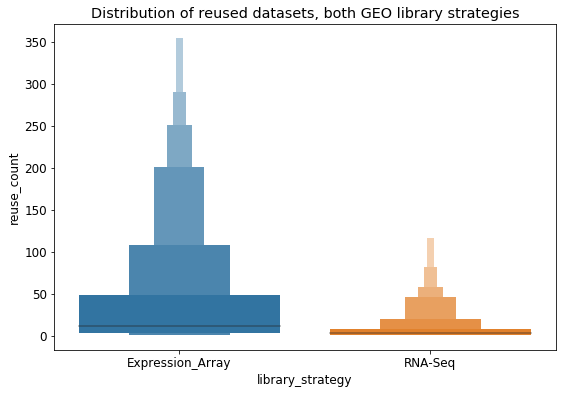

In [38]:
# plot reuse per library strategy in GEO, RI

accs_top_libsGEO = accs_feat.loc[accs_feat['repository'] == 'GEO', :]

fig, ax = plt.subplots(figsize=fig_dims)
# s = sns.boxplot(data = accs_top_libsGEO.loc[accs_top_libsGEO['reuse_count'] > 0, :], 
#                 x = 'library_strategy', y = 'reuse_count', showfliers = False, ax = ax)
s = sns.boxenplot(data = accs_top_libsGEO.loc[accs_top_libsGEO['reuse_count'] > 0, :], 
                x = 'library_strategy', y = 'reuse_count', ax = ax)
# s.set(yscale = 'log')
title = "Distribution of reused datasets, both GEO library strategies"
ax.set_title(title)
plt.savefig("../figures/geoLibstratDist.png")
plt.show()

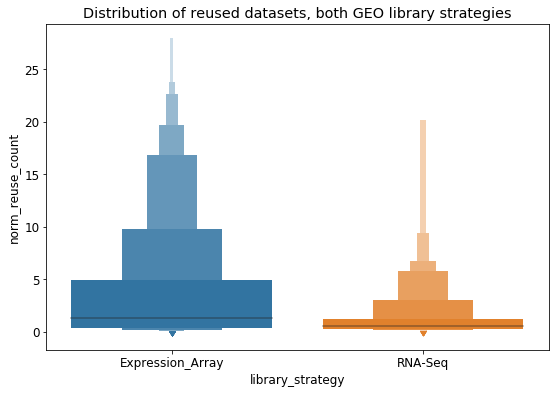

In [98]:
# plot reuse per library strategy in GEO, NRI

accs_top_libsGEO = accs_feat.loc[accs_feat['repository'] == 'GEO', :]

fig, ax = plt.subplots(figsize=fig_dims)
# s = sns.boxplot(data = accs_top_libsGEO.loc[accs_top_libsGEO['reuse_count'] > 0, :], 
#                 x = 'library_strategy', y = 'reuse_count', showfliers = False, ax = ax)
s = sns.boxenplot(data = accs_top_libsGEO.loc[accs_top_libsGEO['reuse_count'] > 0, :], 
                x = 'library_strategy', y = 'norm_reuse_count', ax = ax)
# s.set(yscale = 'log')
title = "Distribution of reused datasets, both GEO library strategies"
ax.set_title(title)
plt.savefig("../figures/geoLibstratDist_NRI.png")
plt.show()

In [39]:
# # plot library stragegy overlap between SRA and GEO (RNA-Seq)

# accsRS = accs_feat.loc[accs_feat['library_strategy'] == 'RNA-Seq', :]

# fig, ax = plt.subplots(figsize=fig_dims)
# s = sns.boxenplot(data = accsRS.loc[accsRS['reuse_count'] > 0, :], 
#                 x = 'library_strategy', y = 'reuse_count', hue = 'repository', ax = ax)
# # s.set(yscale = 'log')
# title = "Distribution of reused datasets, RNA-Seq"
# ax.set_title(title)
# plt.show()

In [99]:
# # plot reuse per hardware

# hc = Counter(accs_feat['hardware'])

# hwCounts = pd.DataFrame.from_dict(hc, orient = 'index').reset_index()
# hwCounts.columns = ['hardware', 'count']

# NUM_TOPHWS = 15

# topHws = hwCounts.dropna().sort_values(by = 'count', ascending = False).head(n = NUM_TOPHWS)['hardware'].to_list()

# accs_top_hws = accs_feat.loc[inList(accs_feat['hardware'], topHws), :].sort_values(by = 'reuse_count', ascending = False)

In [100]:
# fig, ax = plt.subplots(figsize=fig_dims)
# # s = sns.boxenplot(data = accs_top_hws.loc[accs_top_hws['reuse_count'] > 0, :], x = 'hardware', y = 'reuse_count', hue = 'repository', ax = ax)
# s = sns.boxplot(data = accs_top_hws.loc[accs_top_hws['reuse_count'] > 0, :], 
#                 x = 'hardware', y = 'reuse_count', hue = 'class', showfliers = False, ax = ax)
# s.set(yscale = 'log')
# s.set_xticklabels(s.get_xticklabels(), rotation = 90)
# title = "Distribution of reused datasets, top " + str(NUM_TOPHWS) + " types of sequencing hardware"
# ax.set_title(title)
# plt.savefig("../figures/hardwareDist.png")
# plt.show()

In [101]:
# # plot reuse by impact factor

# # import data
# if_table = pd.read_csv("../data_tables/impactFactor_table.csv")
# if_table = if_table.drop(['journal', 'pmc_ID'], axis = 1).drop_duplicates().dropna()
# avgIFs = if_table.groupby('converted_accession', as_index = False).agg({'ImpactFactor':'max'})
# if_table = pd.merge(avgIFs, if_table, on = 'converted_accession', how = 'left')
# if_table = if_table.rename(columns = {'ImpactFactor_x':'MAX_ImpactFactor', 'ImpactFactor_y':'ImpactFactor'})
# # if_table

In [102]:
# if_table = if_table.drop(['ImpactFactor'], axis = 1).drop_duplicates()
# # if_table

In [103]:
# fig, ax = plt.subplots(figsize=(12, 9))
# s = sns.scatterplot(data = if_table.loc[if_table['reuse_count'] > 0, :], x = 'MAX_ImpactFactor', y = 'reuse_count', hue = 'repository', ax = ax)
# s.set(yscale = 'log')
# title = "Reuse count per maximum journal impact factor"
# ax.set_title(title)
# plt.show()

In [104]:
# # plot reuse by access restrictions

# # Counter(accs_feat.loc[accs_feat['repository'] == 'SRA', :]['sraAccess'])

# fig, ax = plt.subplots(figsize=fig_dims)
# # sns.boxenplot(data = accs_feat.loc[accs_feat['repository'] == 'SRA', :].loc[accs_feat['reuse_count'] > 0], x = 'sraAccess', y = 'reuse_count', ax = ax)
# sns.boxplot(data = accs_feat.loc[accs_feat['repository'] == 'SRA', :].loc[accs_feat['reuse_count'] > 0], x = 'sraAccess', y = 'reuse_count', ax = ax)
# s.set(yscale = 'log')
# s.set_xticklabels(s.get_xticklabels(), rotation = 90)
# title = "Distribution of reused datasets in SRA by access restrictions"
# ax.set_title(title)
# plt.show()

In [105]:
# # plot reuse versus sample size

# fig, ax = plt.subplots(figsize=fig_dims)
# s = sns.scatterplot(data = accs_feat, x = 'sraBases', y = 'reuse_count')
# title = "Reuse per number of bases (SRA studies)"
# ax.set_title(title)
# plt.show()

In [106]:
# determine the top 10 most reused datasets

NUM_MOSTREUSED = 10

most_reused = accs_feat[['converted_accession', 'reuse_count']].drop_duplicates().sort_values(by = 'reuse_count', ascending = False).head(n = NUM_MOSTREUSED)
most_reused

,converted_accession,reuse_count
880,GPL570,1095.0
594,GPL96,520.0
620,GSE2034,354.0
1255,GSE7390,290.0
162,GSE1456,269.0
716,GSE3494,251.0
14924,GSE31210,249.0
1294,GSE6532,239.0
16251,GSE14520,234.0
44,GSE506,216.0
